<a href="https://colab.research.google.com/github/RomainViardLille/formation_deeplearning/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [38]:
%matplotlib inline


In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-9senhs8y
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-9senhs8y
  Resolved https://github.com/albumentations-team/albumentations to commit fe249f572df79a56259f7b878a3951d79fd64b92
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [3]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


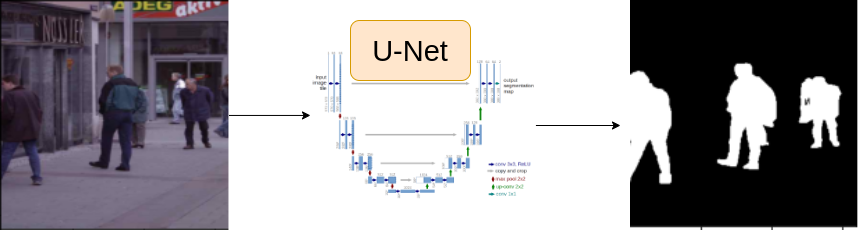

# Some Common Imports

In [4]:
import sys,os
sys.path.append(os.path.join("/NAS","tupac","romain","git","myGitHUB","formation_deeplearning","Human-Segmentation-Dataset-master"))

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
# prompt: create variable with csv file of content (os.path.join)

import os
csv_file = os.path.join("/NAS","tupac","romain","git","myGitHUB","formation_deeplearning","Human-Segmentation-Dataset-master",'train.csv')

DEVICE='cuda'
EPOCHS=25
LR=0.003
IMAGE_SIZE=320
BATCH_SIZE=16
ENCODER ='time-zfficientnet-b0'
WEIGHTS='imagenet'

NUM_WORKERS=2
PIN_MEMORY=True
LOAD_MODEL=False


In [7]:
df=pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row=df.iloc[0]
image_path=row.images
mask_path=row.masks
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
print(f"Image Shape : {image.shape}")
print(f"Mask Shape : {mask.shape}")


Image Shape : (183, 276)
Mask Shape : (183, 276)


In [9]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=41)

In [39]:
def show_image(image,mask):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

  ax1.set_title('IMAGE')
  ax1.imshow(image)

  ax2.set_title('GROUND TRUTH')
  ax2.imshow(mask,cmap = 'gray')

TypeError: Invalid shape (3, 320, 320) for image data

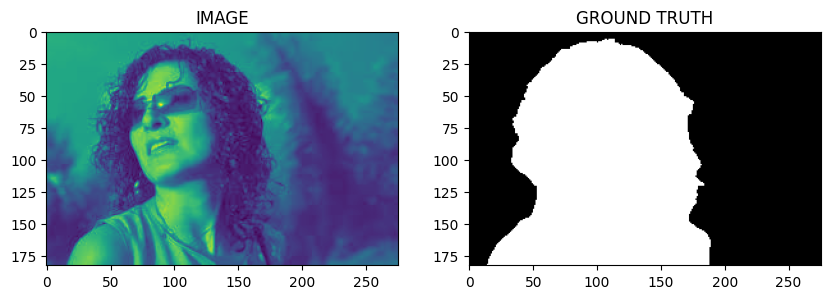

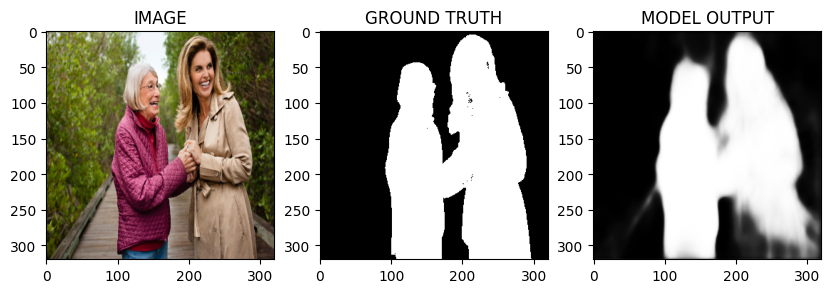

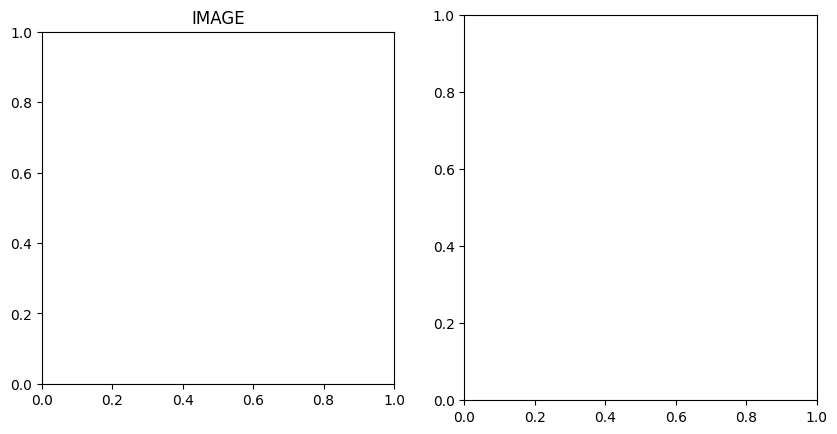

In [40]:
show_image(image,mask)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [13]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [14]:
from torch.utils.data import Dataset
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    #print(row)
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask=np.expand_dims(mask,axis=-1)

    transform = A.Resize(IMAGE_SIZE,IMAGE_SIZE)
    image=transform(image=image)['image']
    mask=transform(image=mask)['image']

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)      
      image=data['image']
      mask=data['mask']

    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.tensor(image) / 255.0
    mask=torch.round(torch.tensor(mask) / 255.0)

    return image,mask

In [15]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [19]:
trainloader=DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True
)
validloader=DataLoader(
    validset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False
)

In [20]:
for image,mask in trainloader:
    print(f"Image batch shape : {image.shape} \n")

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Image batch shape : torch.Size([8, 3, 320, 320]) 



In [21]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 15
Total no. of batches in validloader : 4


In [22]:
for image,mask in validloader:
  print(f"Image batch shape : {image.shape} \n")
  print(f"Mask batch shape : {mask.shape} \n")
  #break

#print(f"Image batch shape : {image.shape}")
#print(f"Mask batch shape : {mask.shape}")

Image batch shape : torch.Size([16, 3, 320, 320]) 

Mask batch shape : torch.Size([16, 1, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Mask batch shape : torch.Size([16, 1, 320, 320]) 

Image batch shape : torch.Size([16, 3, 320, 320]) 

Mask batch shape : torch.Size([16, 1, 320, 320]) 

Image batch shape : torch.Size([10, 3, 320, 320]) 

Mask batch shape : torch.Size([10, 1, 320, 320]) 



# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [23]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [24]:
class SegmentationModel(nn.Module):
    
  def __init__(self):
    super(SegmentationModel,self).__init__()
    
    self.arc=smp.Unet(
        encoder_name='resnet18',
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )
    
  def forward(self,images,masks=None):
    logits=self.arc(images)
    if masks != None:
        loss1=DiceLoss(mode='binary')(logits,masks)
        loss2=nn.BCEWithLogitsLoss()(logits,masks)
        return logits,loss1+loss2
    return logits

In [25]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

# Task 7 : Create Train and Validation Function

In [26]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0

  for images,masks in tqdm(data_loader):
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)

In [27]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss=0.0

  #with torch.no.grad():
  if True :
    for images,masks in tqdm(data_loader):
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)

      logits,loss=model(images,masks)

      total_loss+=loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [28]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)


In [29]:
best_valid_loss=np.Inf
for i in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss < best_valid_loss:
    best_valid_loss=valid_loss
    torch.save(model.state_dict(),'best_model.pt')
    print('Saved Best Model!')

  print(f"Epoch : {i+1}")
  print(f"Train Loss : {train_loss}")
  print(f"Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Saved Best Model!
Epoch : 1
Train Loss : 1.0658756097157795
Valid Loss : 30.713889122009277


100%|██████████| 4/4 [00:00<00:00,  8.55it/s]


Saved Best Model!
Epoch : 2
Train Loss : 0.8637879053751628
Valid Loss : 1.642419844865799


100%|██████████| 4/4 [00:00<00:00,  9.17it/s]


Saved Best Model!
Epoch : 3
Train Loss : 0.7616193334261576
Valid Loss : 1.266483634710312


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Saved Best Model!
Epoch : 4
Train Loss : 0.7007442831993103
Valid Loss : 1.006058543920517


100%|██████████| 4/4 [00:00<00:00,  7.18it/s]


Epoch : 5
Train Loss : 0.6457580129305521
Valid Loss : 1.1032960265874863


100%|██████████| 4/4 [00:00<00:00,  9.30it/s]


Saved Best Model!
Epoch : 6
Train Loss : 0.6434435367584228
Valid Loss : 0.6470581069588661


100%|██████████| 4/4 [00:00<00:00,  8.14it/s]


Saved Best Model!
Epoch : 7
Train Loss : 0.6049725333849589
Valid Loss : 0.5914187282323837


100%|██████████| 4/4 [00:00<00:00,  7.79it/s]


Epoch : 8
Train Loss : 0.5868876079718272
Valid Loss : 0.7815321534872055


100%|██████████| 4/4 [00:00<00:00,  7.32it/s]


Saved Best Model!
Epoch : 9
Train Loss : 0.581354029973348
Valid Loss : 0.5530280917882919


100%|██████████| 4/4 [00:00<00:00,  8.29it/s]


Saved Best Model!
Epoch : 10
Train Loss : 0.5142781833807627
Valid Loss : 0.5103311687707901


100%|██████████| 4/4 [00:00<00:00,  8.59it/s]


Epoch : 11
Train Loss : 0.5199670414129893
Valid Loss : 0.6971466690301895


100%|██████████| 4/4 [00:00<00:00,  8.59it/s]


Epoch : 12
Train Loss : 0.513051857550939
Valid Loss : 0.8682738840579987


100%|██████████| 4/4 [00:00<00:00,  8.67it/s]


Epoch : 13
Train Loss : 0.47787634531656903
Valid Loss : 0.6279775351285934


100%|██████████| 4/4 [00:00<00:00,  8.67it/s]


Epoch : 14
Train Loss : 0.4961210429668427
Valid Loss : 0.8155867159366608


100%|██████████| 4/4 [00:00<00:00,  8.26it/s]


Saved Best Model!
Epoch : 15
Train Loss : 0.43577224810918175
Valid Loss : 0.4945135936141014


100%|██████████| 4/4 [00:00<00:00,  8.02it/s]


Epoch : 16
Train Loss : 0.4394892712434133
Valid Loss : 0.5296569168567657


100%|██████████| 4/4 [00:00<00:00,  8.52it/s]


Epoch : 17
Train Loss : 0.4397301018238068
Valid Loss : 0.5049957036972046


100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


Saved Best Model!
Epoch : 18
Train Loss : 0.39909244775772096
Valid Loss : 0.43469198793172836


100%|██████████| 4/4 [00:00<00:00,  8.90it/s]


Saved Best Model!
Epoch : 19
Train Loss : 0.3634930491447449
Valid Loss : 0.42323680222034454


100%|██████████| 4/4 [00:00<00:00,  7.39it/s]


Saved Best Model!
Epoch : 20
Train Loss : 0.3886020123958588
Valid Loss : 0.4227669760584831


100%|██████████| 4/4 [00:00<00:00,  8.79it/s]


Epoch : 21
Train Loss : 0.3919063687324524
Valid Loss : 0.4875750318169594


100%|██████████| 4/4 [00:00<00:00,  7.81it/s]


Epoch : 22
Train Loss : 0.3493982990582784
Valid Loss : 0.48226088285446167


100%|██████████| 4/4 [00:00<00:00,  8.66it/s]


Epoch : 23
Train Loss : 0.366749037305514
Valid Loss : 0.4856164753437042


100%|██████████| 4/4 [00:00<00:00,  8.39it/s]


Epoch : 24
Train Loss : 0.34423966507116954
Valid Loss : 0.480870857834816


100%|██████████| 4/4 [00:00<00:00,  8.61it/s]

Epoch : 25
Train Loss : 0.30230569541454316
Valid Loss : 0.5902443006634712


# Task 9 : Inference

In [56]:
idx=26
model.load_state_dict(torch.load('best_model.pt'))
image,mask=validset[idx]
logits=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits)
pred_msak=(pred_mask>0.5)*1.0

/tmp/ipykernel_90370/1808845799.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


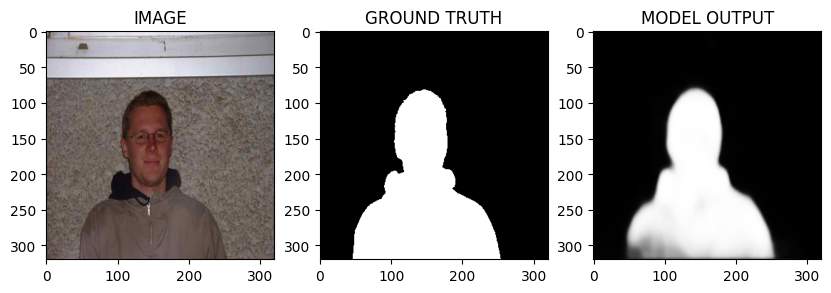

In [57]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya